In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

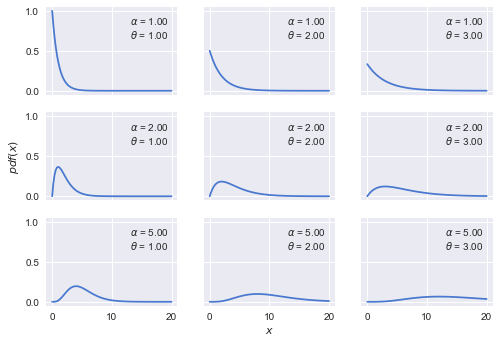

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')
plt.savefig('B04958_04_00.png', dpi=300, figsize=(5.5, 5.5));

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


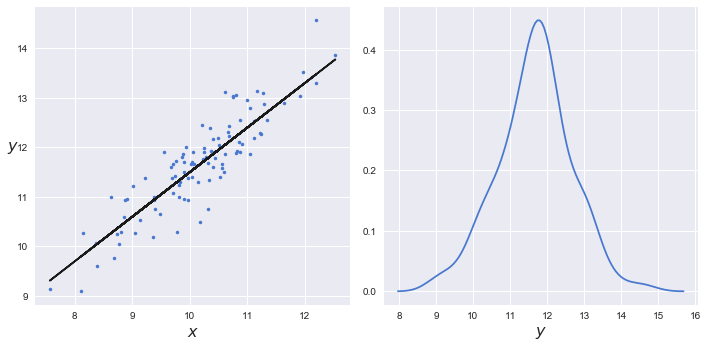

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start)

Optimization terminated successfully.
         Current function value: 67.459649
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26


100%|██████████| 10000/10000 [00:02<00:00, 3833.79it/s]


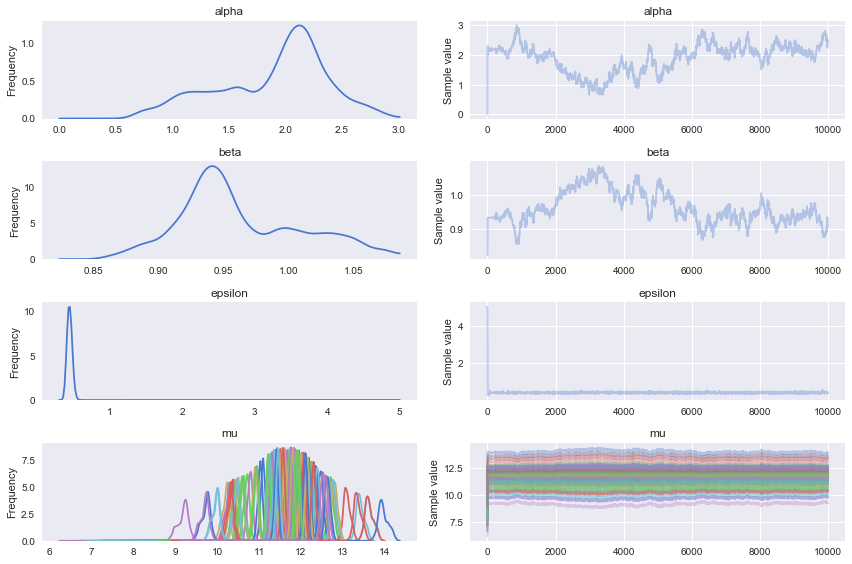

In [6]:
pm.traceplot(trace)
plt.savefig('B04958_04_03.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
#pm.df_summary(trace)

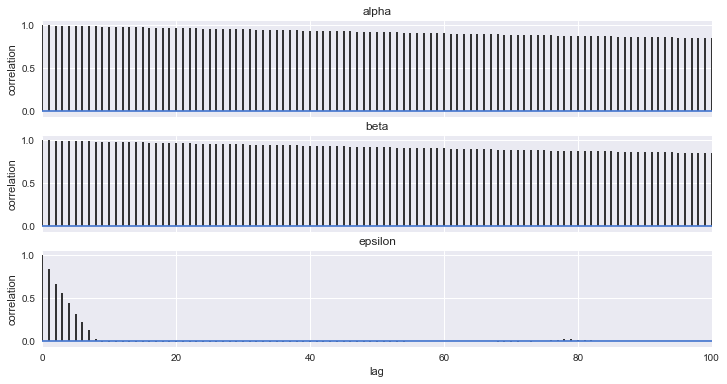

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.savefig('B04958_04_04.png', dpi=300, figsize=(5.5, 5.5));

### Modyfing the data before running the models

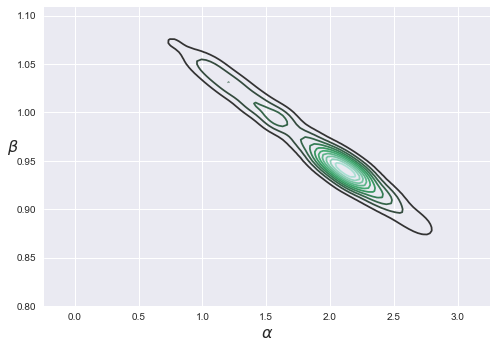

In [9]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.savefig('B04958_04_05.png', dpi=300, figsize=(5.5, 5.5));

### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS() 
    trace_n = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.


100%|██████████| 2000/2000 [00:28<00:00, 70.92it/s] 

         Current function value: 67.459649
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26


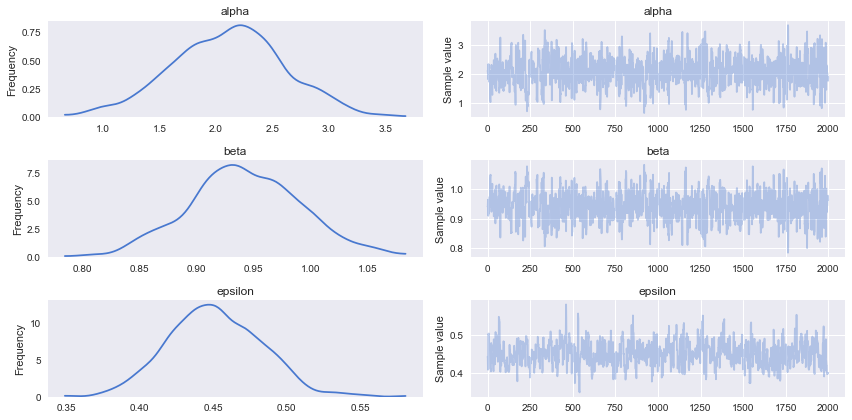

In [11]:
pm.traceplot(trace_n, varnames);

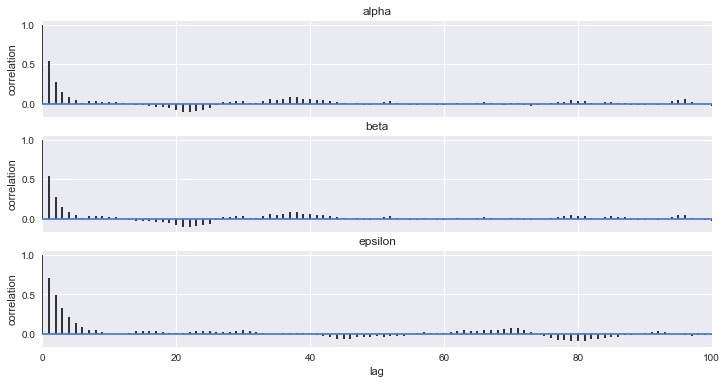

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.df_summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.11,0.50,1.89e-02,1.18,3.15
beta,0.94,0.05,1.87e-03,0.84,1.04
epsilon,0.45,0.03,1.57e-03,0.39,0.51


### Posterior predictive checks

In [14]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

100%|██████████| 231/231 [00:02<00:00, 89.94it/s]


/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


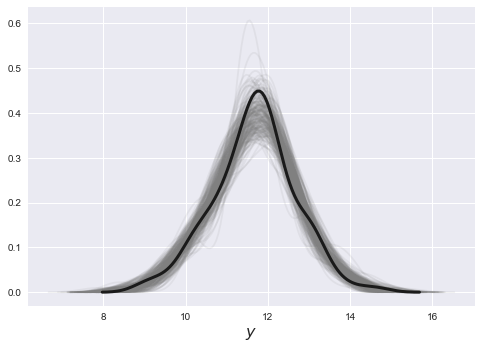

In [15]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior

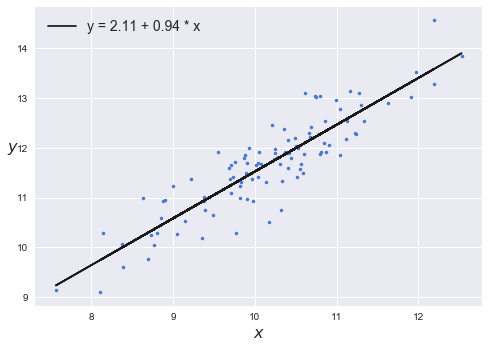

In [16]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_06.png', dpi=300, figsize=(5.5, 5.5));

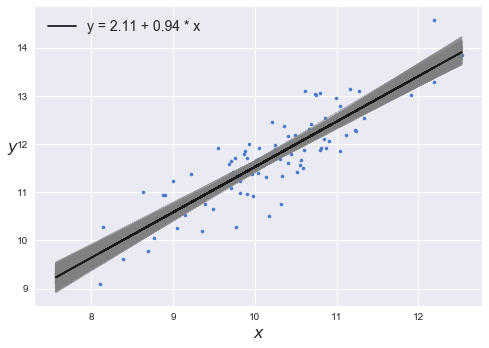

In [17]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_07.png', dpi=300, figsize=(5.5, 5.5));

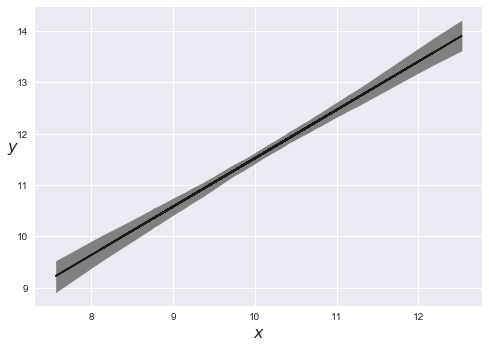

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_08.png', dpi=300, figsize=(5.5, 5.5));

In [19]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

100%|██████████| 1000/1000 [00:11<00:00, 86.18it/s]


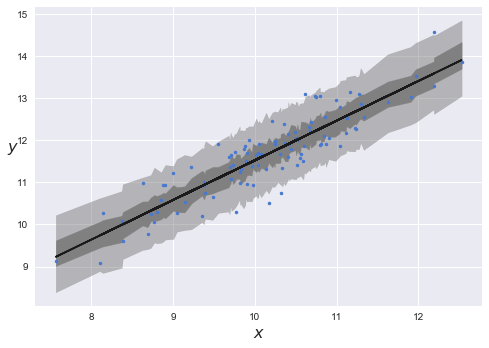

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_09.png', dpi=300, figsize=(5.5, 5.5));

## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 67.459649
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26

100%|██████████| 2000/2000 [00:29<00:00, 67.30it/s] 

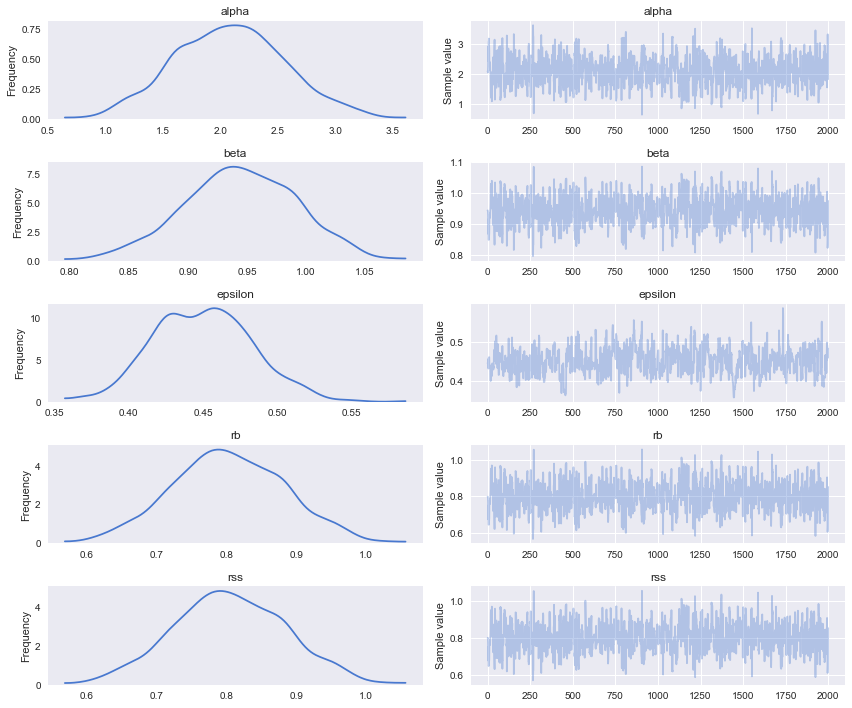

In [22]:
pm.traceplot(trace_n)
plt.savefig('B04958_04_10.png', dpi=300, figsize=(5.5, 5.5));

In [23]:
pm.df_summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.08,0.48,1.78e-02,1.17,3.06
beta,0.94,0.05,1.74e-03,0.85,1.04
epsilon,0.45,0.03,1.76e-03,0.39,0.52
rb,0.80,0.08,2.94e-03,0.65,0.96
rss,0.80,0.08,2.93e-03,0.65,0.96


### The multivariate normal distribution 
Actualy the bivariate

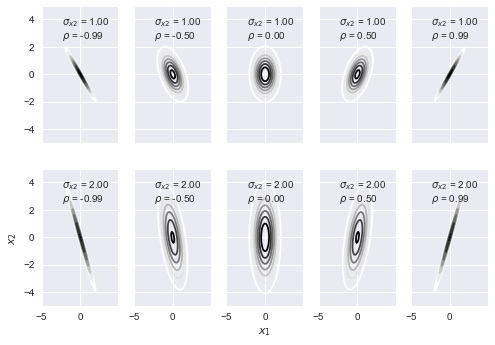

In [24]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
plt.savefig('B04958_04_11.png', dpi=300, figsize=(5.5, 5.5));

In [25]:
data = np.stack((x, y)).T

In [26]:
with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_p = pm.sample(1000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 209.396961

100%|██████████| 1000/1000 [00:11<00:00, 87.39it/s]


         Iterations: 16
         Function evaluations: 25
         Gradient evaluations: 25


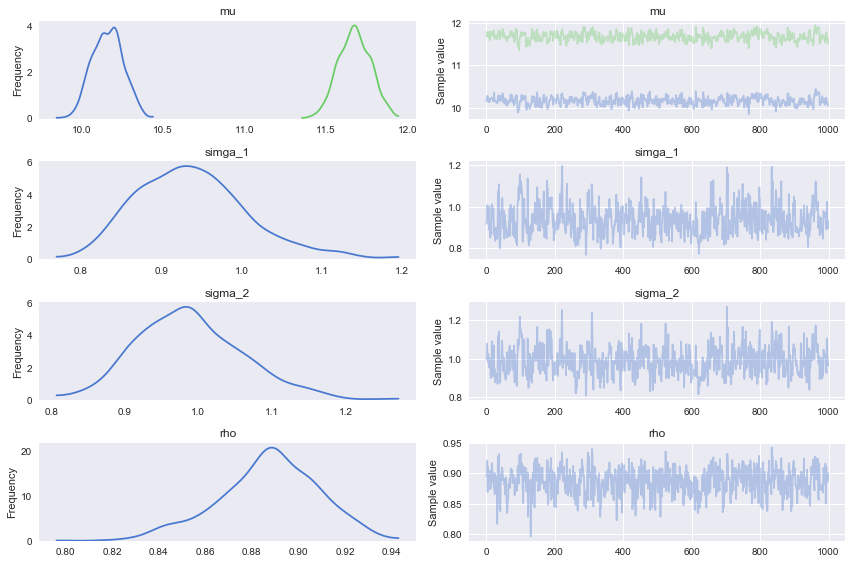

In [27]:
pm.traceplot(trace_p);
plt.savefig('B04958_04_12.png', dpi=300, figsize=(5.5, 5.5));

In [28]:
pm.df_summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu__0,10.16,0.09,5.44e-03,9.99,10.34
mu__1,11.67,0.10,5.70e-03,11.49,11.87
simga_1,0.94,0.07,3.57e-03,0.81,1.08
sigma_2,0.99,0.07,3.79e-03,0.86,1.14
rho,0.89,0.02,1.05e-03,0.84,0.93


## Robust linear regression

In [29]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


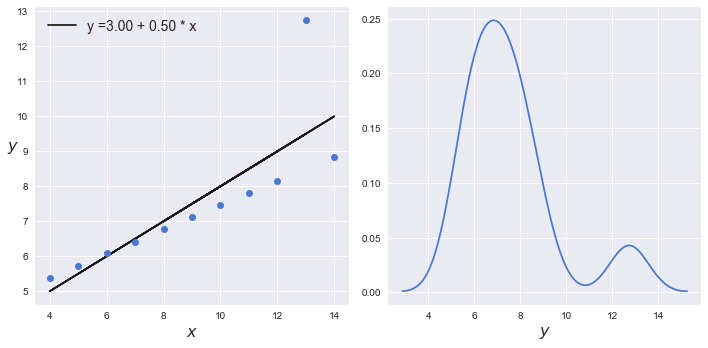

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_13.png', dpi=300, figsize=(5.5, 5.5));

In [31]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(2000, step=step, start=start)

         Current function value: -11.957256
         Iterations: 43
         Function evaluations: 207
         Gradient evaluations: 193


100%|██████████| 2000/2000 [00:10<00:00, 184.03it/s]


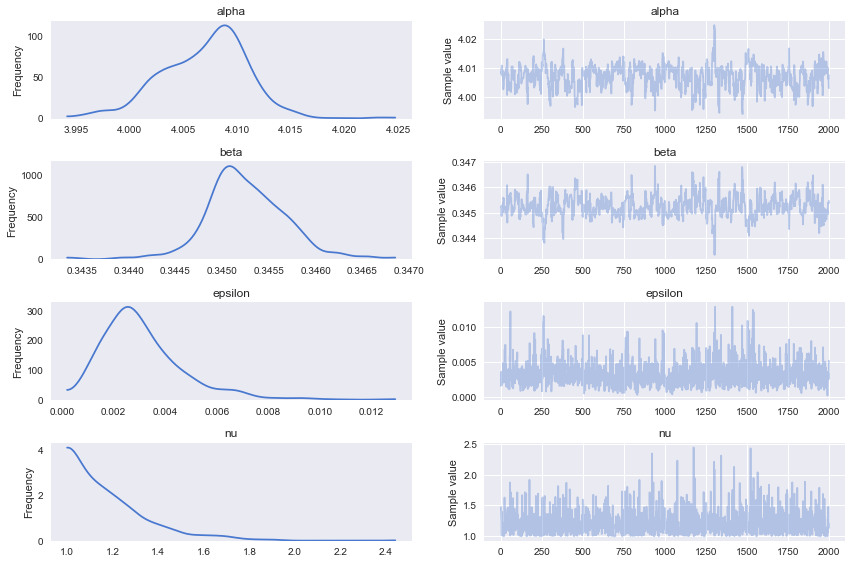

In [32]:
pm.traceplot(trace_t);

In [33]:
pm.df_summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.01e+00,4.02e-03,2.54e-04,4.00e+00,4.02e+00
beta,3.45e-01,4.28e-04,2.75e-05,3.44e-01,3.46e-01
epsilon,3.17e-03,1.70e-03,6.34e-05,5.28e-04,6.65e-03
nu,1.20e+00,1.90e-01,4.71e-03,1.00e+00,1.60e+00


In [34]:
#pm.autocorrplot(cadena_t, varnames);

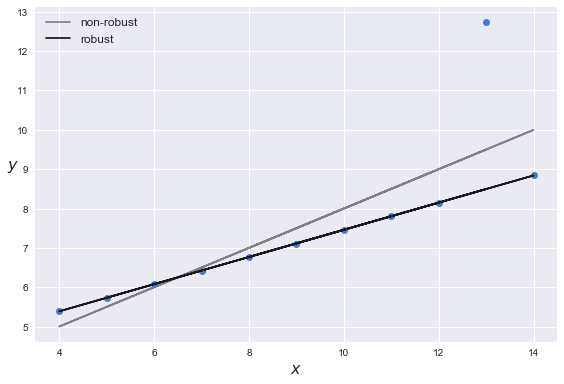

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

plt.savefig('B04958_04_14.png', dpi=300, figsize=(5.5, 5.5));

In [36]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:03<00:00, 55.22it/s]


/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


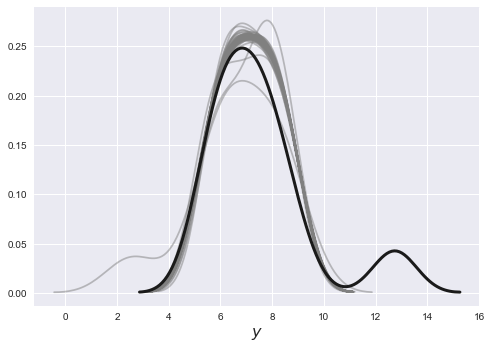

In [37]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)
plt.savefig('B04958_04_15.png', dpi=300, figsize=(5.5, 5.5));

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


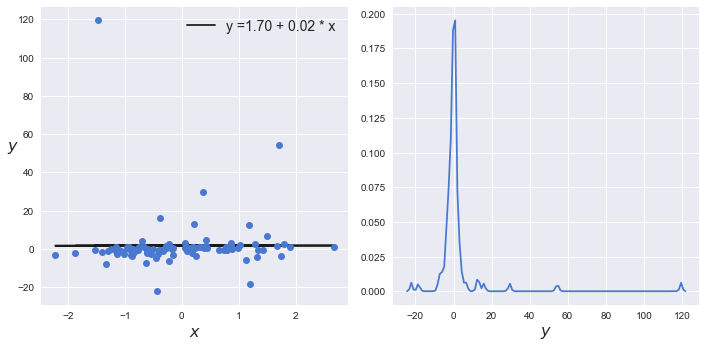

In [38]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

In [39]:
with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    #nu = pm.Gamma('nu', mu=20, sd=15)
    #nu = pm.Gamma('nu', 2, 0.1)

    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=epsilon, nu=nu, observed=y_4)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t2 = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 272.389099
         Iterations: 13


100%|██████████| 2000/2000 [00:04<00:00, 483.07it/s]

         Function evaluations: 16
         Gradient evaluations: 16


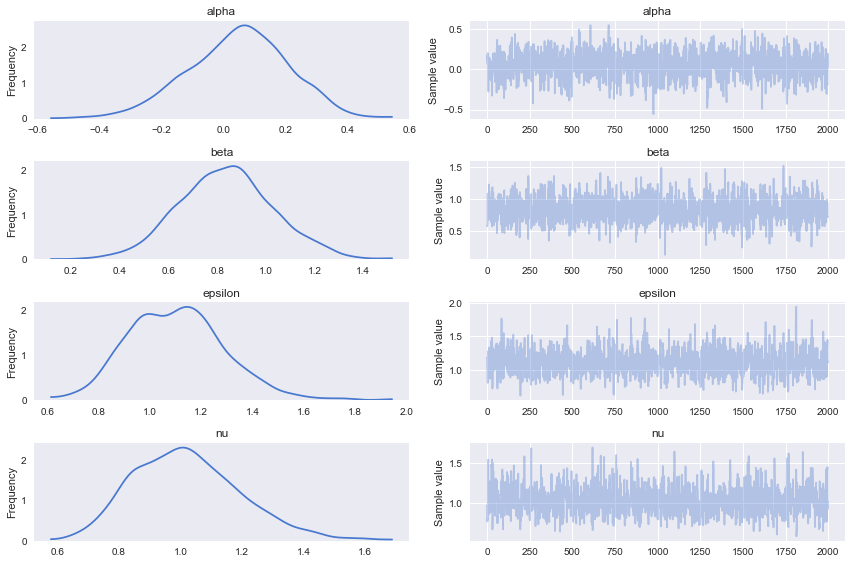

In [40]:
pm.traceplot(trace_t2);

In [41]:
pm.df_summary(trace_t2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.05,0.16,4.51e-03,-0.27,0.34
beta,0.83,0.19,4.25e-03,0.49,1.24
epsilon,1.10,0.19,5.77e-03,0.78,1.48
nu,1.02,0.18,5.41e-03,0.69,1.36


In [45]:
x_4

array([ 0.17,  0.78,  0.85, -0.71, -0.93,  0.89, -0.22,  0.38, -0.77,
        0.86, -0.28, -0.93, -0.5 ,  0.76,  0.19, -0.62,  1.67,  1.74,
        1.18,  1.12, -1.87, -0.64, -0.76,  2.66,  0.17,  0.18,  1.32,
        0.44,  0.2 , -1.53, -0.34, -0.96, -0.23, -1.15, -0.42,  1.33,
       -0.93,  0.11, -1.1 , -0.87, -0.88,  0.4 ,  0.05, -0.85,  0.99,
        0.3 ,  1.71, -0.38, -0.27, -1.14, -0.4 , -0.9 , -0.46,  0.22,
        0.66, -1.15, -0.17, -1.01,  0.18, -1.25,  0.36,  1.48, -0.28,
        0.42, -0.55,  0.24, -0.37,  0.86, -1.4 ,  1.41, -0.44,  1.2 ,
       -1.47, -0.16, -0.67, -1.03,  1.29,  0.16, -0.83,  1.89,  1.79,
        0.09,  0.06, -0.15, -0.85, -0.6 ,  0.86, -2.22,  0.33, -1.29,
        0.85, -1.34,  0.21, -0.6 ,  0.24,  0.73,  1.02,  0.09, -1.07,  0.42])

In [49]:
x_3

array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])

In [47]:
y_4.shape

(100,)

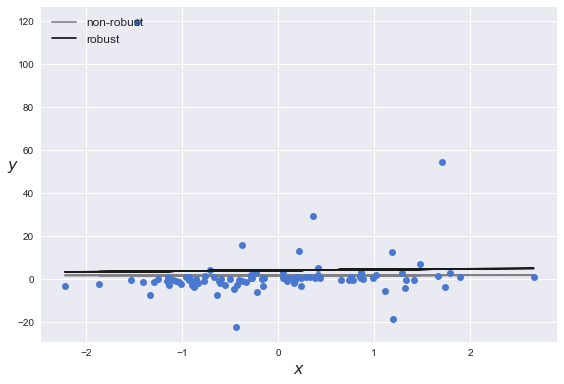

In [50]:
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]

plt.plot(x_4, (alpha_c + beta_c * x_4), 'k', label='non-robust', alpha=0.5)
plt.plot(x_4, y_4, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_4, alpha_m + beta_m * x_4, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

## Hierarchical linear regression

In [51]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

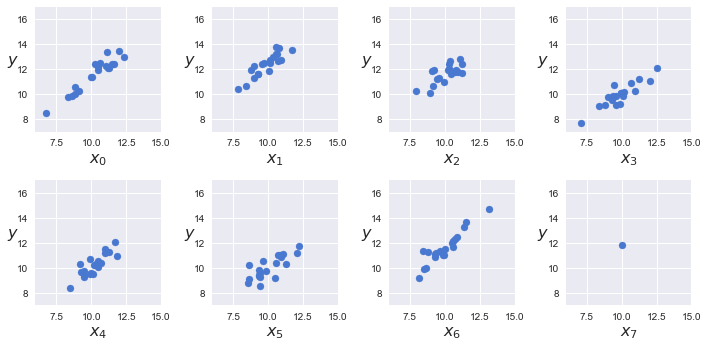

In [52]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300, figsize=(5.5, 5.5));

In [53]:
x_centered = x_m - x_m.mean()

In [54]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 147.870275
         Iterations: 41

100%|██████████| 2000/2000 [00:11<00:00, 176.79it/s]


         Function evaluations: 54
         Gradient evaluations: 54


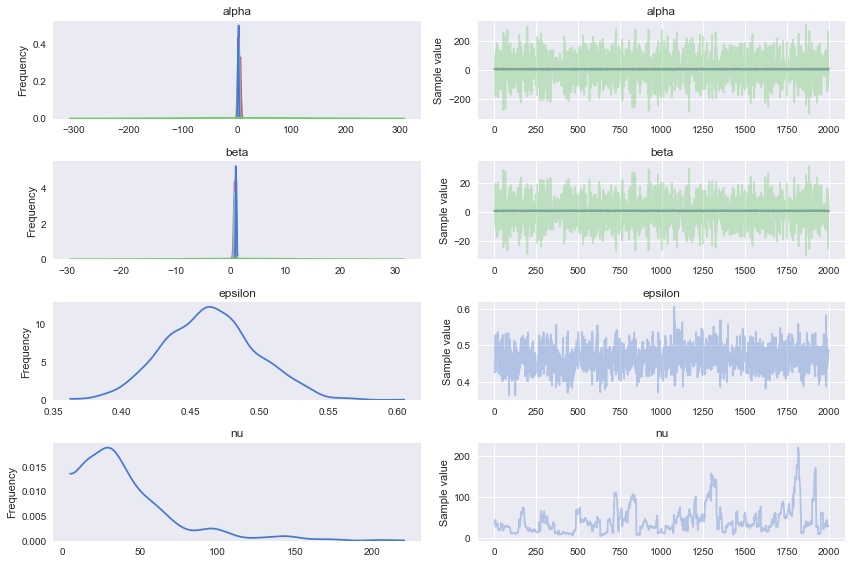

In [55]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)
plt.savefig('B04958_04_17.png', dpi=300, figsize=(5.5, 5.5));

In [56]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [57]:
pm.df_summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.44,0.77,1.57e-02,1.01,3.99
alpha__1,3.69,1.17,2.17e-02,1.58,6.00
alpha__2,5.65,1.27,2.18e-02,3.07,8.13
alpha__3,3.07,0.90,1.73e-02,1.22,4.67
alpha__4,1.36,1.31,2.77e-02,-1.18,3.92
alpha__5,3.26,0.99,1.95e-02,1.43,5.20
alpha__6,1.78,0.91,1.93e-02,0.09,3.63
alpha__7,10.36,101.60,2.08e+00,-201.81,186.98
beta__0,0.89,0.08,1.52e-03,0.74,1.04
beta__1,0.88,0.12,2.24e-03,0.65,1.10


In [58]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

Average ELBO = -135.94: 100%|██████████| 100000/100000 [00:18<00:00, 5516.95it/s]
Finished [100%]: Average ELBO = -135.85
100%|██████████| 1000/1000 [00:14<00:00, 67.79it/s]


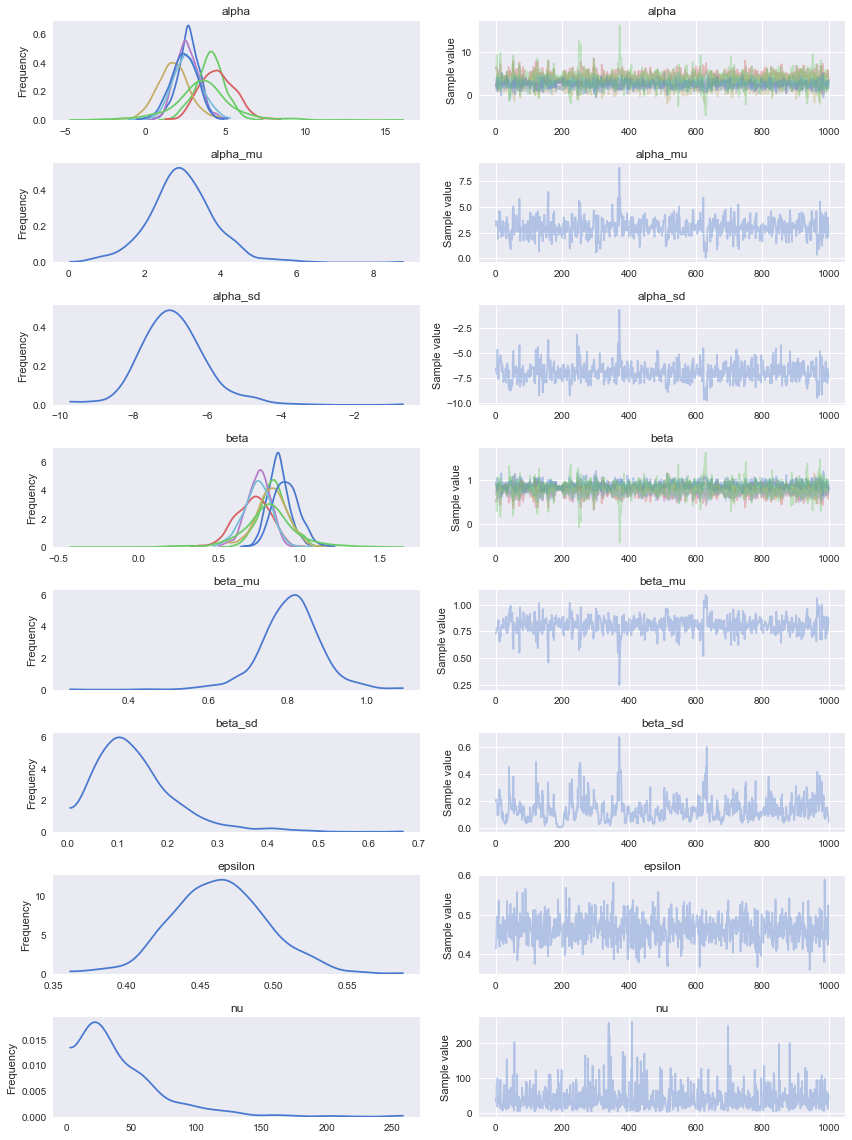

In [59]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
plt.savefig('B04958_04_19.png', dpi=300, figsize=(5.5, 5.5));

In [60]:
pm.df_summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.71,0.66,2.17e-02,1.27e+00,3.90
alpha__1,4.05,0.89,2.72e-02,2.21e+00,5.70
alpha__2,4.52,1.10,5.26e-02,2.59e+00,6.66
alpha__3,2.61,0.73,2.96e-02,1.23e+00,4.02
alpha__4,1.72,1.02,3.51e-02,-3.00e-01,3.75
alpha__5,2.63,0.90,4.11e-02,8.96e-01,4.40
alpha__6,2.41,0.84,3.68e-02,7.30e-01,3.95
alpha__7,3.55,1.95,1.01e-01,-9.05e-01,7.36
alpha_mu,3.00,0.88,4.53e-02,1.09e+00,4.58
alpha_sd,-6.92,0.90,4.44e-02,-8.43e+00,-4.82


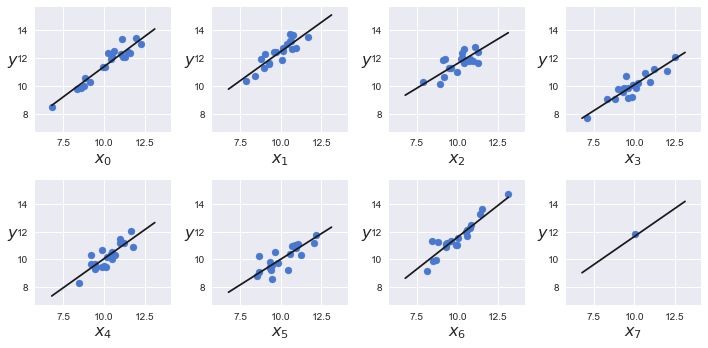

In [62]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

## Polynomial regression

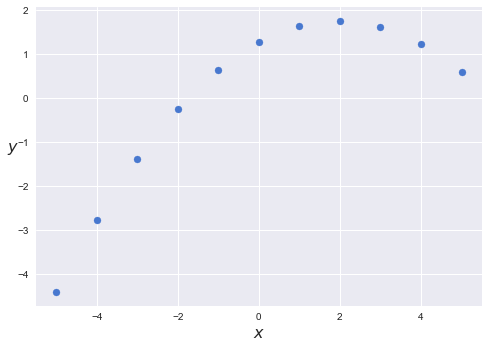

In [63]:
#ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300, figsize=(5.5, 5.5))

In [64]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_poly = pm.sample(2000, step=step, start=start)

         Current function value: -42.680369
         Iterations: 37
         Function evaluations: 115
         Gradient evaluations: 106


100%|██████████| 2000/2000 [00:06<00:00, 328.22it/s]


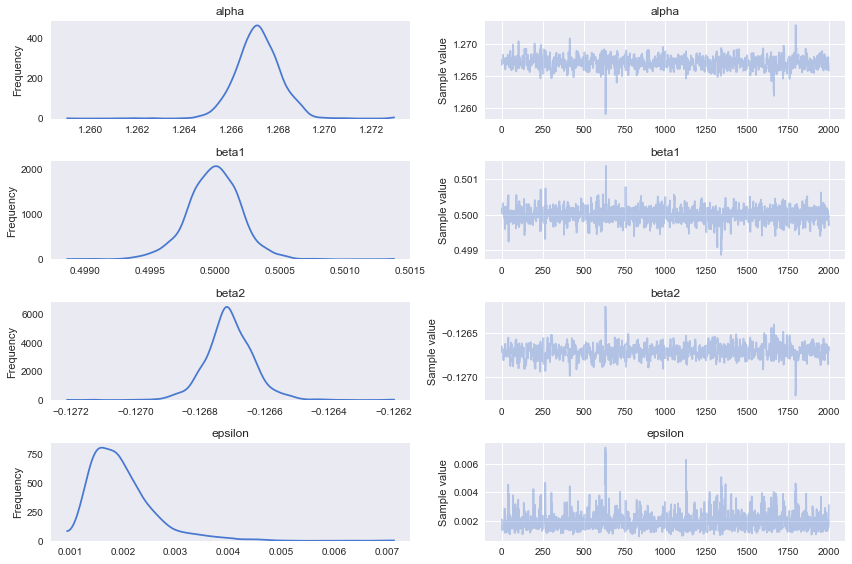

In [65]:
pm.traceplot(trace_poly)
plt.savefig('B04958_04_22.png', dpi=300, figsize=(5.5, 5.5))

In [66]:
pm.df_summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.27e+00,9.68e-04,3.94e-05,1.27e+00,1.27e+00
beta1,5.00e-01,2.05e-04,6.40e-06,5.00e-01,5.00e-01
beta2,-1.27e-01,7.52e-05,3.12e-06,-1.27e-01,-1.27e-01
epsilon,1.99e-03,6.21e-04,2.25e-05,1.08e-03,3.23e-03


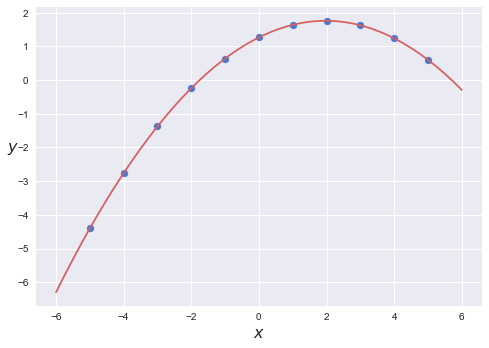

In [67]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='r')
plt.savefig('B04958_04_23.png', dpi=300, figsize=(5.5, 5.5))

## Multiple Linear regression

In [68]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

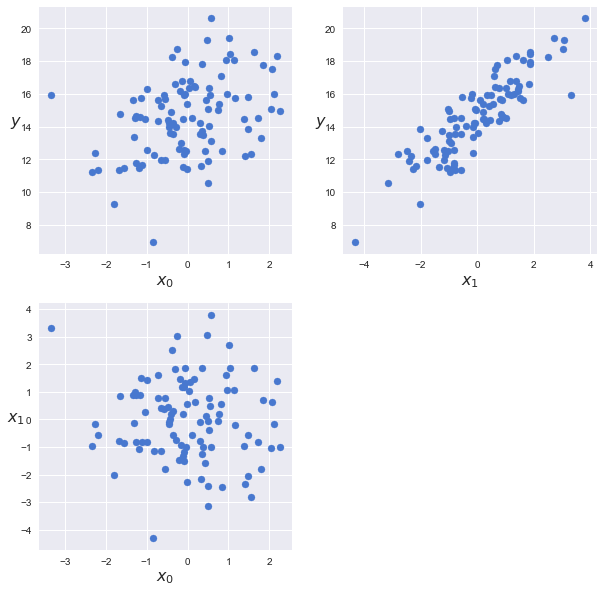

In [69]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300, figsize=(5.5, 5.5))

In [70]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 74.986175
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:08<00:00, 620.68it/s] 


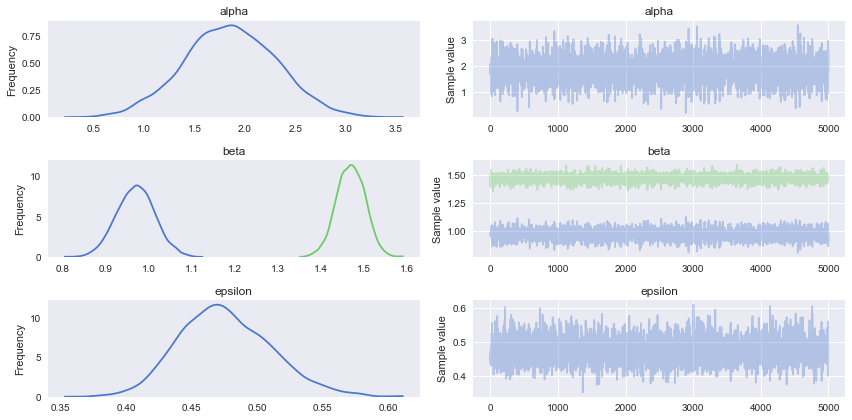

In [71]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)
plt.savefig('B04958_04_26.png', dpi=300, figsize=(5.5, 5.5));

In [72]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.46,6.03e-03,0.92,2.71
beta__0,0.97,0.04,5.92e-04,0.89,1.06
beta__1,1.47,0.03,4.90e-04,1.40,1.53
epsilon,0.48,0.03,5.72e-04,0.41,0.55


In [73]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.46,6.03e-03,0.92,2.71
beta__0,0.97,0.04,5.92e-04,0.89,1.06
beta__1,1.47,0.03,4.90e-04,1.40,1.53
epsilon,0.48,0.03,5.72e-04,0.41,0.55


## Confounding variables and redundant variables

In [74]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

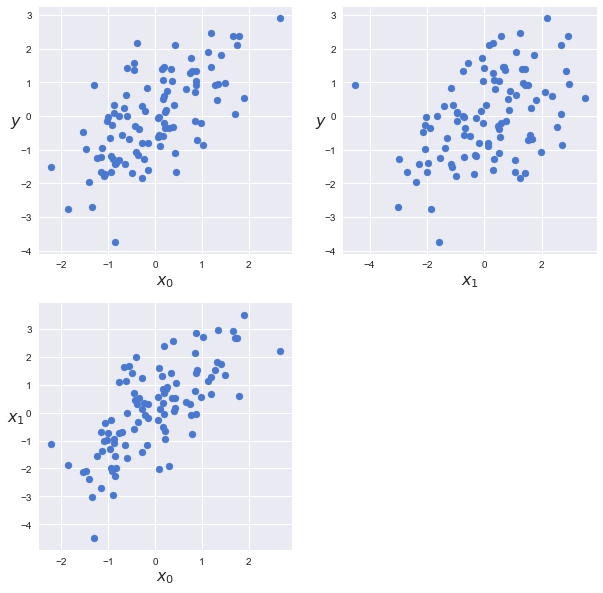

In [75]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300, figsize=(5.5, 5.5));

In [76]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.


100%|██████████| 5000/5000 [00:06<00:00, 764.63it/s] 

         Current function value: 149.147667
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19


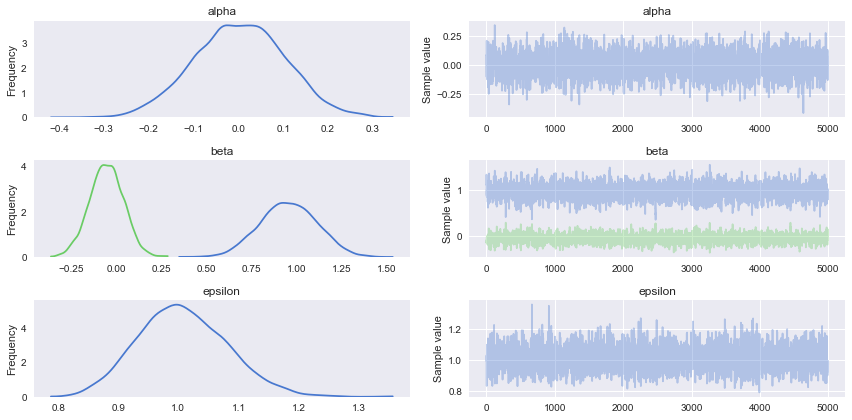

In [77]:
pm.traceplot(trace_red)
plt.savefig('B04958_04_28.png', dpi=300, figsize=(5.5, 5.5))

In [78]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.93e-03,0.10,1.57e-03,-0.20,0.19
beta__0,9.58e-01,0.16,3.48e-03,0.64,1.25
beta__1,-5.38e-02,0.09,2.30e-03,-0.24,0.12
epsilon,1.01e+00,0.07,1.06e-03,0.86,1.14


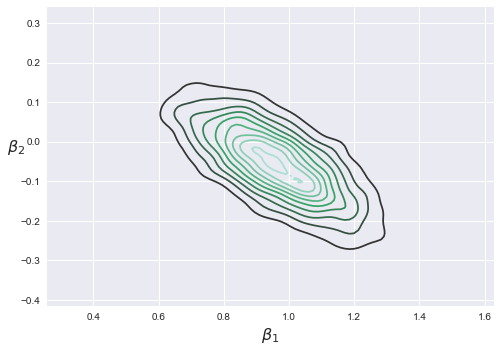

In [79]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
#plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

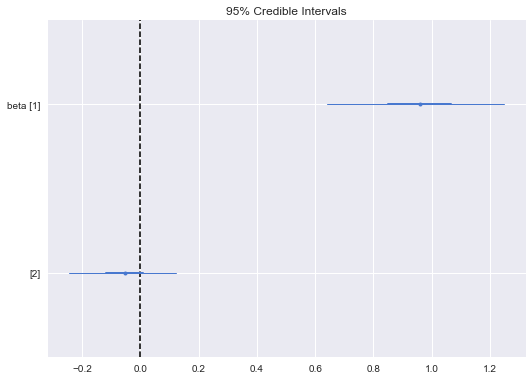

In [80]:
pm.forestplot(trace_red, varnames=['beta'])
#plt.savefig('B04958_04_30.png', dpi=300, figsize=(5.5, 5.5))

## Masking effect variables

In [81]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

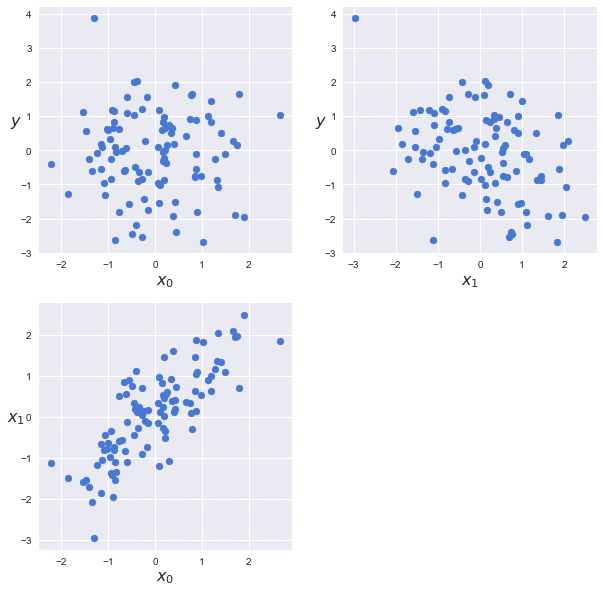

In [82]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300, figsize=(5.5, 5.5));

In [83]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ma = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 151.456313
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 5000/5000 [00:06<00:00, 781.69it/s] 


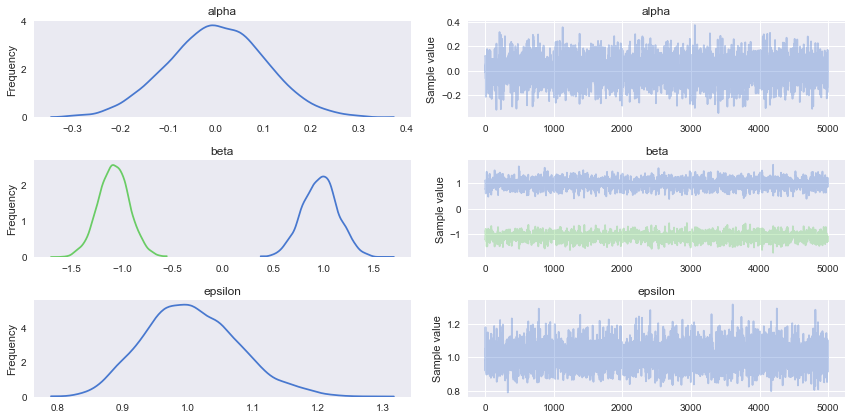

In [84]:
pm.traceplot(trace_ma)
plt.savefig('B04958_04_32.png', dpi=300, figsize=(5.5, 5.5));

In [85]:
pm.df_summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.23e-03,0.10,1.53e-03,-0.20,0.20
beta__0,9.68e-01,0.18,5.07e-03,0.62,1.31
beta__1,-1.08e+00,0.15,4.35e-03,-1.37,-0.77
epsilon,1.00e+00,0.07,1.11e-03,0.88,1.16


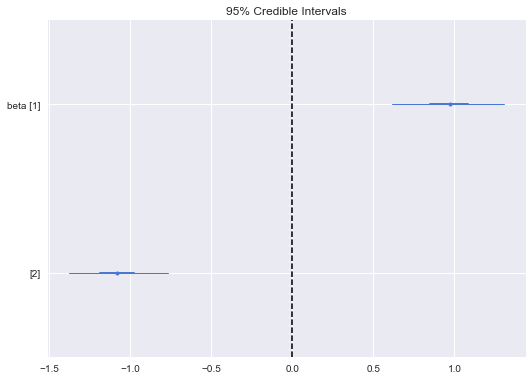

In [86]:
pm.forestplot(trace_ma, varnames=['beta']);
plt.savefig('B04958_04_33.png', dpi=300, figsize=(5.5, 5.5));

In [87]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo   y usando:
Python 3.6.0
IPython 5.1.0
PyMC3 3.0
NumPy 1.11.3
SciPy 0.18.1
Matplotlib 2.0.0
Seaborn 0.7.1

